<a href="https://colab.research.google.com/github/talhaanwarch/Plant-Leaf-Disease-Classification/blob/master/stratified_aug.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://github.com/mjkvaak/ImageDataAugmentor.git

Cloning into 'ImageDataAugmentor'...
remote: Enumerating objects: 98, done.
remote: Counting objects: 100% (98/98), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 263 (delta 54), reused 38 (delta 15), pack-reused 165
Receiving objects: 100% (263/263), 130.33 KiB | 356.00 KiB/s, done.
Resolving deltas: 100% (153/153), done.


In [0]:
%%capture
!wget https://data.mendeley.com/datasets/3f83gxmv57/2/files/53398b67-6f0e-4a67-8384-e2b574b2ebf4/Citrus.zip

In [0]:
%%capture
!unzip /content/Citrus.zip

In [0]:
%%capture
!pip install efficientnet

In [0]:
import glob
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [0]:
def auto_canny(image, sigma=0.33):
	# compute the median of the single channel pixel intensities
	v = np.median(image)
	# apply automatic Canny edge detection using the computed median
	lower = int(max(0, (1.0 - sigma) * v))
	upper = int(min(255, (1.0 + sigma) * v))
	edged = cv2.Canny(image, lower, upper)
  ## find the non-zero min-max coords of canny
	pts = np.argwhere(edged>0)
	y1,x1 = pts.min(axis=0)
	y2,x2 = pts.max(axis=0)
	cropped = image[y1:y2, x1:x2]
	return cropped

#canny_img=auto_canny(img)




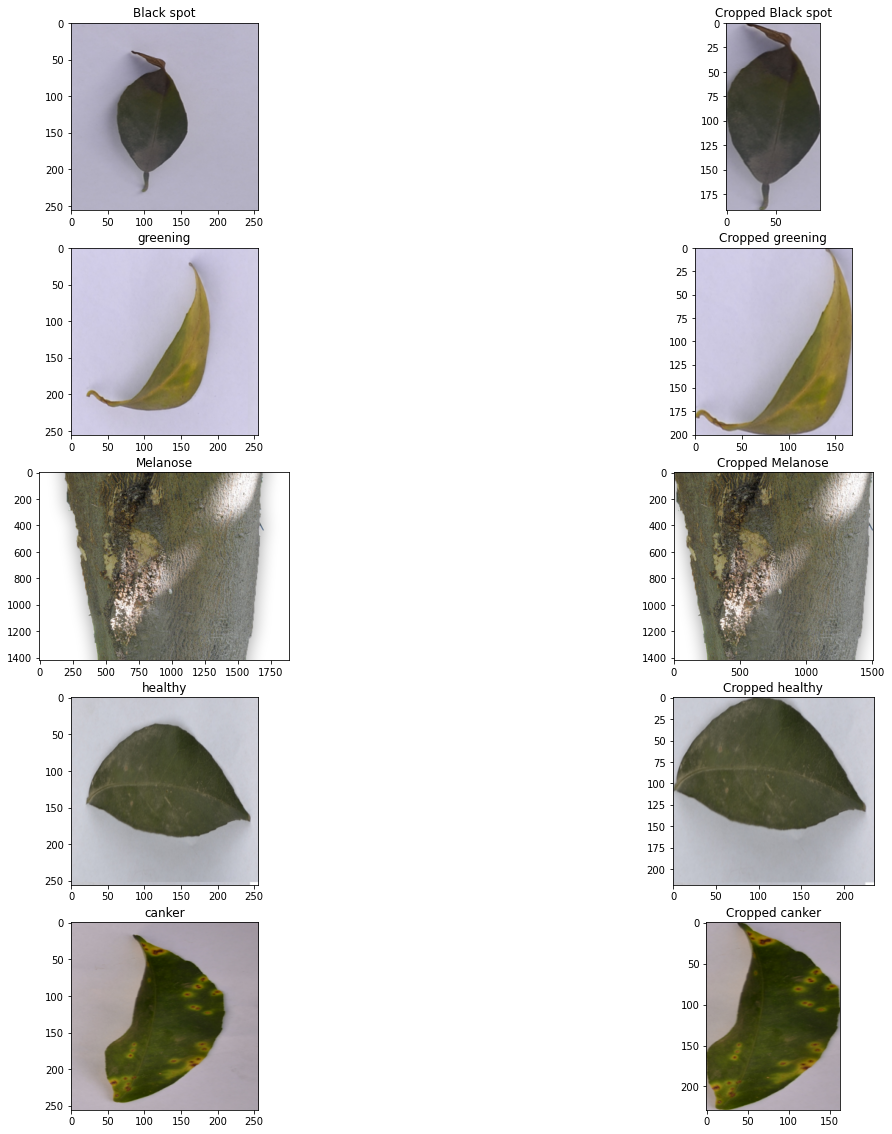

In [31]:
import random
from glob import glob

pic_dir='/content/Citrus/Leaves/'
folder=os.listdir(pic_dir)
fig,ax=plt.subplots(nrows=len(folder),ncols=2,figsize=(20,20))
for j,i in enumerate(folder):
  pic_path=random.choice(os.listdir(pic_dir+i))
  pic=cv2.imread(pic_dir+i+'/'+pic_path)
  pic=cv2.cvtColor(pic,cv2.COLOR_BGR2RGB)
  canny_img=auto_canny(pic)
  ax[j,0].imshow(pic)
  ax[j,1].imshow(canny_img)
  ax[j,0].set_title(i)
  ax[j,1].set_title('Cropped '+i)


In [0]:
Black_spot=os.listdir('/content/Citrus/Leaves/Black spot')
Melanose=os.listdir('/content/Citrus/Leaves/Melanose')
canker=os.listdir('//content/Citrus/Leaves/canker')
greening=os.listdir('/content/Citrus/Leaves/greening')
healthy=os.listdir('/content/Citrus/Leaves/healthy')


In [0]:
def encode(category,category_name):
  category=list(zip(category,['{}'.format(category_name)]*(len(category))))
  category_df = pd.DataFrame(category,columns=['file','label']) 
  return category_df



In [0]:
Black_spot_df=encode(Black_spot,'Black_spot')
Melanose_df=encode(Melanose,'Melanose')
canker_df=encode(canker,'canker')
greening_df=encode(greening,'greening')
healthy_df=encode(healthy,'healthy')

In [35]:
dataframe=pd.concat([Black_spot_df,Melanose_df,canker_df,greening_df,healthy_df])
dataframe.head()

,file,label
0,b (98).png,Black_spot
1,b (273).png,Black_spot
2,b (56).png,Black_spot
3,b (84).png,Black_spot
4,b (222).png,Black_spot


In [36]:
dataframe['label'].value_counts()

greening      204
Black_spot    171
canker        163
healthy        58
Melanose       13
Name: label, dtype: int64

In [0]:
dataframe=dataframe.sample(frac=1)

In [0]:
!mkdir data

In [0]:
!cp -r /content/Citrus/Leaves/Black\ spot/* data
!cp -r /content/Citrus/Leaves/Melanose/* data
!cp -r /content/Citrus/Leaves/canker/* data
!cp -r /content/Citrus/Leaves/healthy/* data
!cp -r /content/Citrus/Leaves/greening/* data


In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from albumentations import *


In [0]:
aug=Compose([
        RandomRotate90(),
        Flip(),
        Transpose(),
        OneOf([
            IAAAdditiveGaussianNoise(),
            GaussNoise(),
            
        ], p=0.2),
        OneOf([
            MotionBlur(p=.2),
            MedianBlur(blur_limit=3, p=.1),
            Blur(blur_limit=3, p=.1),
        ], p=0.3),
        ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=.2),
        OneOf([
            OpticalDistortion(p=0.3),
            GridDistortion(p=.1),
            IAAPiecewiseAffine(p=0.3),
        ], p=0.3),
        OneOf([
            CLAHE(clip_limit=2),
            IAASharpen(),
            IAAEmboss(),
            RandomContrast(),
            RandomBrightness(),
        ], p=0.3),
        #HueSaturationValue(p=0.3),
    ], p=1)

In [42]:
#from keras_preprocessing.image import ImageDataGenerator
from ImageDataAugmentor.image_data_augmentor import *
data_gen= ImageDataAugmentor(
    #horizontal_flip=True,
    #vertical_flip=True,
    #rotation_range=90,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # zoom_range=.2,
    rescale=1/255,
    # fill_mode='nearest',
    # shear_range=0.2,
    # brightness_range=[0.2, 2.0],
    augment =aug)

Using TensorFlow backend.


In [0]:
img_shape=300
batch_size=16

In [0]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPool2D, BatchNormalization,Input,MaxPooling2D,GlobalMaxPooling2D,concatenate
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import tensorflow as tf

In [0]:
df_images=dataframe['file']
df_labels=dataframe['label']
col=['Black_spot','Melanose','canker','greening','healthy']

In [50]:
from sklearn.model_selection import KFold,StratifiedKFold
import gc

from sklearn.metrics import classification_report,accuracy_score,f1_score
classification_reports=[]
kf = StratifiedKFold(n_splits=5)
history=[]
accuracy=[]
f1_macro_scores=[]
f1_weighted_scores=[]
fold=0
for train_index, test_index in kf.split(df_images,df_labels):
  train=dataframe.iloc[train_index,:]
  val=dataframe.iloc[test_index,:]
  df_train = pd.get_dummies(train['label'])
  train = pd.concat([train, df_train], axis=1)

  df_val = pd.get_dummies(val['label'])
  val = pd.concat([val, df_val], axis=1)
  print('-----------fold {}--------------'.format(fold))
  train_generator=data_gen.flow_from_dataframe(train,directory='data',
                                                      target_size=(img_shape,img_shape),
                                                      x_col="file",
                                                      y_col=col,
                                                      class_mode='raw',
                                                      shuffle=True,
                                                      batch_size=batch_size)

  val_generator=data_gen.flow_from_dataframe(val,directory='data',
                                                        target_size=(img_shape,img_shape),
                                                        x_col="file",
                                                        y_col=col,
                                                        class_mode='raw',
                                                        shuffle=False,
                                                        batch_size=batch_size)
  #train_generator.next()[0].shape,train_generator.next()[1].shape
  import efficientnet.tfkeras as efn
  model =efn.EfficientNetB4(weights ='noisy-student', include_top=False, input_shape = (img_shape,img_shape,3))
    
  x = model.output
  x = GlobalAveragePooling2D()(x)
  x = Dropout(0.3)(x)
  x = Dense(128, activation="relu")(x)
  #x = Dropout(0.3)(x)
  x = Dense(64, activation="relu")(x)
  predictions = Dense(5, activation="softmax")(x)
  model = Model(inputs=model.input, outputs=predictions)

  def custom_loss(y_true, y_pred):
      return tf.keras.losses.categorical_crossentropy(y_true, y_pred, label_smoothing=0.1)
  model.compile(optimizer=Adam(0.0001), loss=custom_loss, metrics=['accuracy'])

  results = model.fit(train_generator,epochs=25,
                              steps_per_epoch=train_generator.n/batch_size,
                              validation_data=val_generator,
                             validation_steps=val_generator.n/batch_size,
                              callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=3, min_lr=0.000001),
                                         ModelCheckpoint('model_{}.hdf5'.format(fold), save_best_only=True, monitor='val_loss', mode='min')
                                         ])
  model.load_weights('model_{}.hdf5'.format(fold))
  val_generator.reset()
  y_pred=model.predict(val_generator,steps=val_generator.n/batch_size,verbose=1)
  y_pred=y_pred.round().astype(int)
  y_true=val.iloc[:,2::]
  classification_reports.append(classification_report(y_true, y_pred,target_names=col))#
  accuracy.append(accuracy_score(y_true,y_pred))
  f1_macro=f1_score(y_true,y_pred,average='macro')
  print('f1_macro score is ', f1_macro)
  f1_macro_scores.append(f1_macro)

  f1_weighted=f1_score(y_true,y_pred,average='weighted')
  print('f1_weighted score is ', f1_weighted)
  f1_weighted_scores.append(f1_weighted)

  fold+=1
  del model
  tf.keras.backend.clear_session()
  gc.collect()
  

-----------fold 0--------------
Found 487 validated image filenames.
Found 122 validated image filenames.
Epoch 1/25
31/30 [==============================] - 51s 2s/step - loss: 1.4903 - accuracy: 0.3984 - val_loss: 1.5846 - val_accuracy: 0.2705 - lr: 1.0000e-04
Epoch 2/25
31/30 [==============================] - 46s 1s/step - loss: 1.1923 - accuracy: 0.6550 - val_loss: 1.4233 - val_accuracy: 0.4262 - lr: 1.0000e-04
Epoch 3/25
31/30 [==============================] - 46s 1s/step - loss: 0.9318 - accuracy: 0.7515 - val_loss: 1.2838 - val_accuracy: 0.5246 - lr: 1.0000e-04
Epoch 4/25
31/30 [==============================] - 45s 1s/step - loss: 0.7618 - accuracy: 0.8152 - val_loss: 1.1365 - val_accuracy: 0.6393 - lr: 1.0000e-04
Epoch 5/25
31/30 [==============================] - 45s 1s/step - loss: 0.7124 - accuracy: 0.8316 - val_loss: 1.1202 - val_accuracy: 0.6639 - lr: 1.0000e-04
Epoch 6/25
31/30 [==============================] - 45s 1s/step - loss: 0.6420 - accuracy: 0.8583 - val_loss:

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1_macro score is  0.7282638349305016
f1_weighted score is  0.7631388849968085
-----------fold 1--------------
Found 487 validated image filenames.
Found 122 validated image filenames.
Epoch 1/25
31/30 [==============================] - 49s 2s/step - loss: 1.5247 - accuracy: 0.4209 - val_loss: 1.5679 - val_accuracy: 0.3361 - lr: 1.0000e-04
Epoch 2/25
31/30 [==============================] - 45s 1s/step - loss: 1.1682 - accuracy: 0.6530 - val_loss: 1.3859 - val_accuracy: 0.4344 - lr: 1.0000e-04
Epoch 3/25
31/30 [==============================] - 45s 1s/step - loss: 0.8668 - accuracy: 0.7762 - val_loss: 1.2230 - val_accuracy: 0.5164 - lr: 1.0000e-04
Epoch 4/25
31/30 [==============================] - 46s 1s/step - loss: 0.8024 - accuracy: 0.7988 - val_loss: 1.1495 - val_accuracy: 0.5574 - lr: 1.0000e-04
Epoch 5/25
31/30 [==============================] - 46s 1s/step - loss: 0.7603 - accuracy: 0.7967 - val_loss: 1.0960 - val_accuracy: 0.5738 - lr: 1.0000e-04
Epoch 6/25
31/30 [============

In [51]:
accuracy

[0.7459016393442623,
 0.7786885245901639,
 0.819672131147541,
 0.8114754098360656,
 0.7355371900826446]

In [52]:
print(np.mean(accuracy))

0.7782549790001355


In [55]:
f1_macro_scores

[0.7282638349305016,
 0.7631388849968085,
 0.7768735952879176,
 0.8077735130856593,
 0.7361471861471862,
 0.8197306791569088,
 0.7863236149276537,
 0.8218173930158847,
 0.7178964046391615,
 0.7596439087380105]

In [54]:
np.mean(f1_scores)

NameError: ignored

In [56]:

for i in range(5):
  print('--------------FOLD {}------------------'.format(i))
  print(classification_reports[i])

--------------FOLD 0------------------
              precision    recall  f1-score   support

  Black_spot       0.87      0.79      0.83        34
    Melanose       1.00      1.00      1.00         2
      canker       0.70      0.70      0.70        33
    greening       0.93      0.90      0.91        41
     healthy       0.25      0.17      0.20        12

   micro avg       0.80      0.75      0.77       122
   macro avg       0.75      0.71      0.73       122
weighted avg       0.78      0.75      0.76       122
 samples avg       0.75      0.75      0.75       122

--------------FOLD 1------------------
              precision    recall  f1-score   support

  Black_spot       0.94      0.83      0.88        35
    Melanose       1.00      1.00      1.00         3
      canker       0.95      0.64      0.76        33
    greening       0.84      0.95      0.89        40
     healthy       0.33      0.36      0.35        11

   micro avg       0.84      0.78      0.81       122